# Drawdowns

* How much time is spent in large drawdowns
* Compare Bitcoin to S&P500 and Nasdaq
* Study individual bitcoin drawdowns and compare to Nasdaq since 70's

In [102]:
# Imports
%matplotlib inline
import quandl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import backtesters
reload(backtesters)
from backtesters import MABacktester # use this to calculate drawdown table

In [2]:
# Get price data 
bitcoin = quandl.get("BCHAIN/MKPRU")
bitcoin.columns = ['Close']
bitcoin = bitcoin.shift(-1) # data set has daily open, we want daily close
sp500 = pd.read_csv('^GSPC.csv', index_col = 0, parse_dates = [0])

In [23]:
nasdaq_full = pd.read_csv('NASDAQCOM.csv', index_col = 0, parse_dates = [0])
nasdaq_full.columns = ['Close']
nasdaq_full.index.name = 'Date'
nasdaq_full[nasdaq_full['Close'] == '.'] = np.NAN
nasdaq_full['Close'] = nasdaq['Close'].astype(float)
nasdaq_full['Close'].fillna(method = 'ffill', inplace = True)

In [26]:
# Remove the 0's and start on same date
bitcoin = bitcoin.loc['2010-08-17':]
sp500 = sp500.loc['2010-08-17':]
nasdaq = nasdaq_full.loc['2010-08-17':].copy()

In [27]:
for df in [bitcoin, sp500, nasdaq]:
    max_so_far = np.maximum.accumulate(df['Close'])
    df['Drawdown%'] = (max_so_far - df['Close']) / max_so_far  * 100

In [28]:
for i in [5,10,20,30,40,50,60]:
    print i,
    for df in [bitcoin, sp500, nasdaq]:   
        print "{:,.1f}%".format(df[df['Drawdown%'] > i].size / float(df.size) * 100),
    print

5 90.1% 16.6% 25.1%
10 87.1% 5.0% 6.0%
20 79.8% 0.0% 0.0%
30 75.0% 0.0% 0.0%
40 70.4% 0.0% 0.0%
50 55.3% 0.0% 0.0%
60 44.4% 0.0% 0.0%


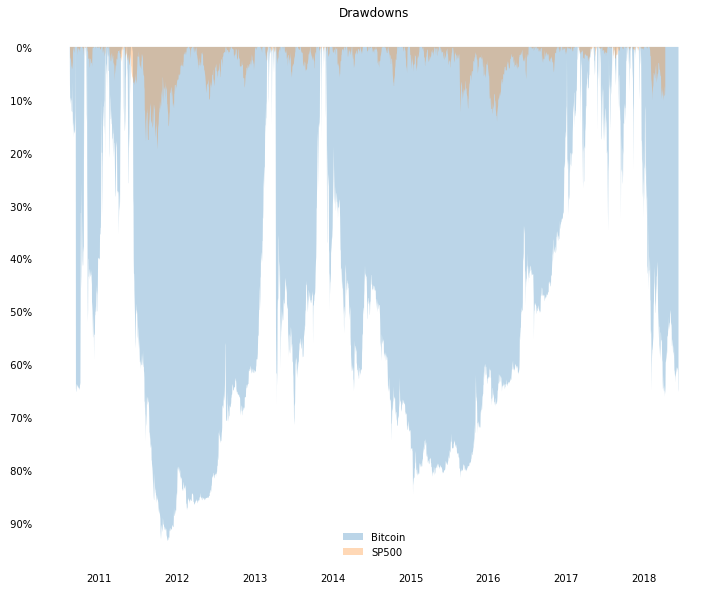

In [29]:
# Comparison of % drawdown over time
#%matplotlib qt5
fig, ax = plt.subplots(figsize=(12,10))
plt.title('Drawdowns')
bitcoin['zero'] = 0
#plt.plot(bitcoin['Drawdown%'])
plt.fill_between(bitcoin['Drawdown%'].index,bitcoin['Drawdown%'].values,0, alpha = 0.3, label="Bitcoin")
plt.fill_between(sp500['Drawdown%'].index,sp500['Drawdown%'].values,0, alpha = 0.3, label = "SP500")
#plt.fill_between(nasdaq['Drawdown%'].index,nasdaq['Drawdown%'].values,0, alpha = 0.3)
plt.legend(loc= "lower center", frameon=False)
#bitcoin['Drawdown%'].plot(label = "Bitcoin", legend = True)
#sp500['Drawdown%'].plot(label = "S&P500", legend = True)
#nasdaq['Drawdown%'].plot(label = "Nasdaq", legend = True)
plt.yticks(np.arange(0,100,10))
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x) for x in vals])
ax.invert_yaxis() # turn up side down
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(top='off', bottom='off', left='off', right='off', labelleft='on', labelbottom='on')
fig.savefig("drawdowns.png", dpi=100, bbox_inches='tight')

In [35]:
bitcoin_drawdowns = MABacktester(bitcoin['Close']).drawdowns(target='market')
bitcoin_drawdowns

,dd,high,low,highd,lowd,days,recoveryd,rdays
0,93.46,35.00000,2.29000,2011-06-09,2011-11-20,164 days,2013-03-03,469 days
1,84.67,1151.00000,176.50000,2013-12-03,2015-01-13,406 days,2017-02-23,772 days
2,71.49,237.99000,67.85844,2013-04-08,2013-07-04,87 days,2013-11-04,123 days
3,66.13,19498.68333,6603.87667,2017-12-16,2018-04-06,111 days,2018-06-11,66 days
4,65.20,0.17500,0.06090,2010-09-14,2010-09-16,2 days,2010-10-23,37 days
5,59.20,0.50000,0.20400,2010-11-06,2010-12-09,33 days,2011-01-31,53 days
6,39.98,7.22000,4.33333,2012-01-05,2012-02-18,44 days,2012-07-09,142 days
7,35.45,1.10000,0.71000,2011-02-09,2011-04-04,54 days,2011-04-17,13 days
8,34.80,2961.82961,1931.21430,2017-06-11,2017-07-16,35 days,2017-08-05,20 days
9,33.83,15.40000,10.18999,2012-08-16,2012-09-01,16 days,2013-01-17,138 days


In [65]:
# plot each of the drawdowns to see the patterns

extra_days = 15 # add some extra days on either side

for index, row in bitcoin_drawdowns.iterrows():    
    #if index > 0:
    #    break
    if row['dd'] < 25: # drawdowns of 25% or more
        break
    high = row['highd']
    recovery = row['recoveryd']
    low = row['lowd']
    start = high - timedelta(days=extra_days)
    end = recovery + timedelta(days=extra_days)
    if row['rdays'].days > 100:
        end += timedelta(days=extra_days)
    if row['rdays'].days > 500:
        end += timedelta(days=extra_days * 4)    
    fig, ax = plt.subplots(figsize=(16,10))
    ax.plot(bitcoin['Close'].loc[start:end].index, bitcoin['Close'].loc[start:end])       
    text = "%.1f%% drop over %d days\nRecovery took %d days" % (row['dd'],row['days'].days,row['rdays'].days)
    if index == 3:
        text = "%.1f%% drop over %d days\nBeen %d days so far" % (row['dd'],row['days'].days,row['rdays'].days)
    ax.plot([high, low, recovery], [bitcoin['Close'].loc[high], bitcoin['Close'].loc[low], bitcoin['Close'].loc[recovery]], 'x', color='Red', markersize=8)
    ax.text(0.5, 0.5,text, horizontalalignment='center', verticalalignment='center', transform = ax.transAxes)
    fig.savefig("drawdowns/bitcoin/" + high.strftime("%Y-%m-%d") + '.png', dpi=100, bbox_inches='tight')
    plt.close(fig)

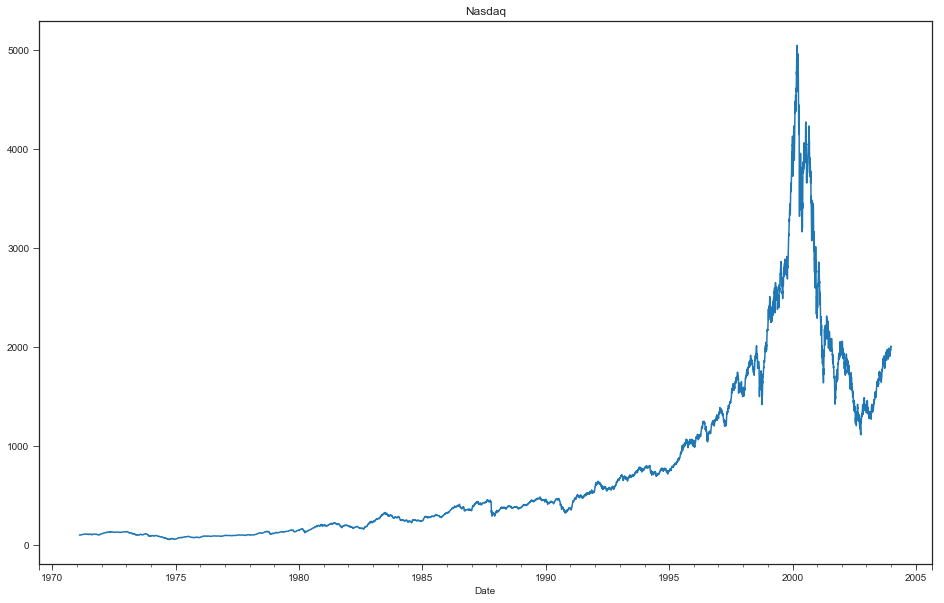

In [160]:
sns.set_style('ticks')
# Do same for Nasdaq
nasdaq_full['Close'].loc[:'2003'].plot(figsize=(16,10))
plt.title('Nasdaq');
#plt.savefig('nasdaq.png', dpi=200, bbox_inches='tight')

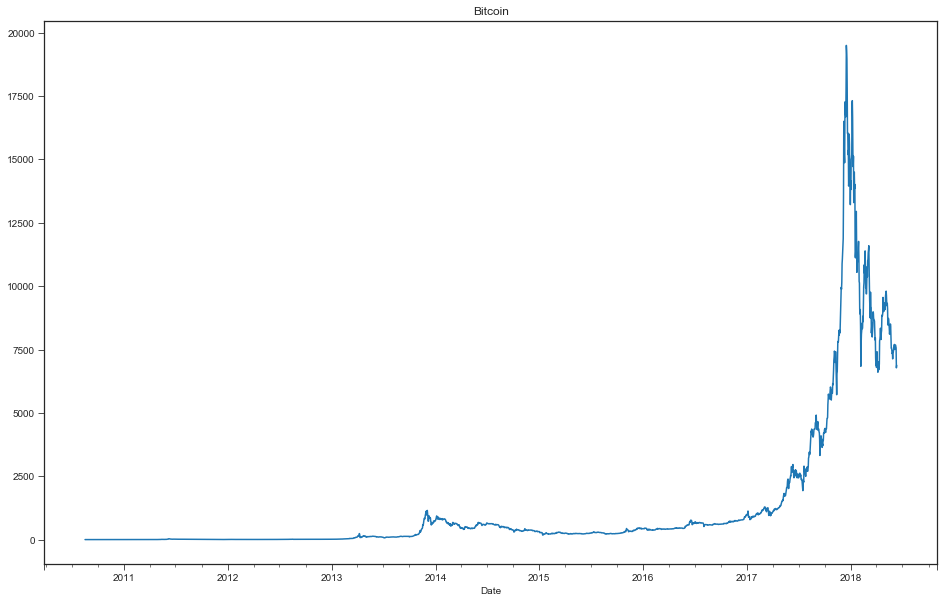

In [161]:
bitcoin['Close'].loc[:'2018'].plot(figsize=(16,10))
plt.title('Bitcoin');
#plt.savefig('bitcoin.png', dpi=200,bbox_inches="tight")

In [162]:
def comparison_chart(first,second,first_label=None,second_label=None):
    sns.set_style('dark')
    fig=plt.figure(figsize=(14,10))
    ax=fig.add_subplot(111, label=first_label)
    ax2=fig.add_subplot(111, label=second_label, frame_on=False)

    ax.plot(first, color="C0")
    ax.set_xlabel(first_label, color="C0")
    ax.set_ylabel(first_label, color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    ax2.plot(second, color="white")
    ax2.xaxis.tick_top()
    ax2.yaxis.tick_right()
    ax2.set_xlabel(second_label, color="gray") 
    ax2.set_ylabel(second_label, color="gray")       
    ax2.xaxis.set_label_position('top') 
    ax2.yaxis.set_label_position('right') 
    ax2.tick_params(axis='x', colors="gray")
    ax2.tick_params(axis='y', colors="gray")
    plt.show()

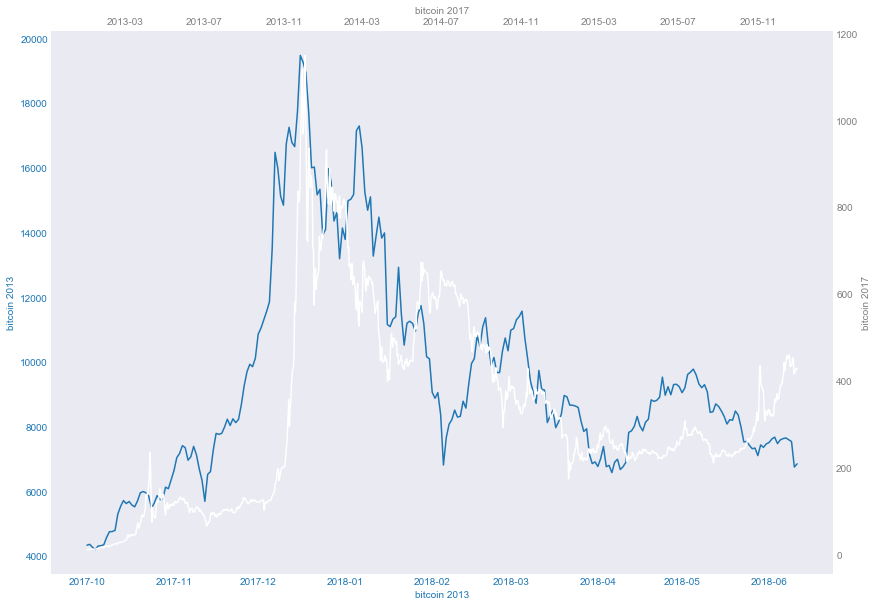

In [141]:
comparison_chart(bitcoin['Close'].loc['2017-10':'2018'],
                 bitcoin['Close'].loc['2013':'2015'],'bitcoin 2013','bitcoin 2017')

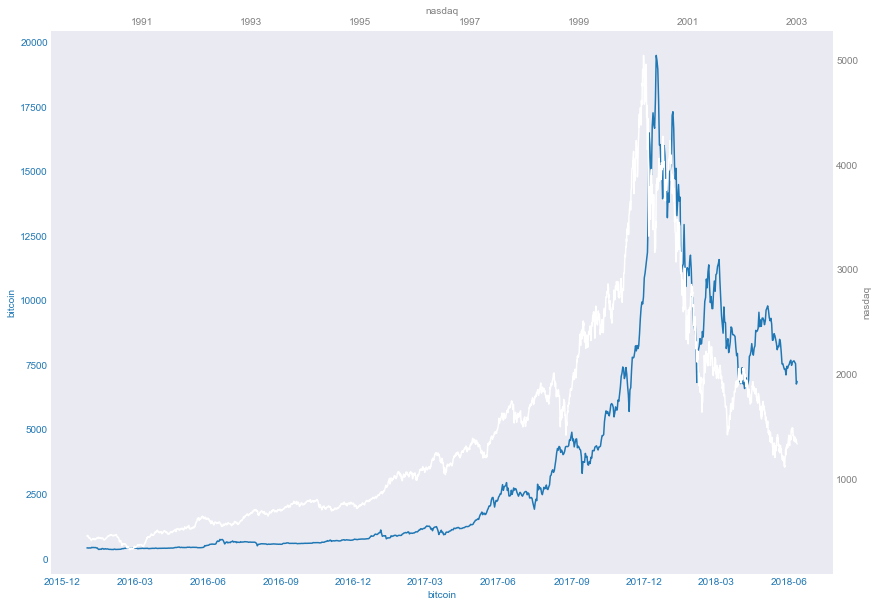

In [144]:
comparison_chart(bitcoin['Close'].loc['2016':'2018'],
                 nasdaq_full['Close'].loc['1990':'2002'],'bitcoin','nasdaq')

In [163]:
nasdaq_drawdowns = MABacktester(nasdaq_full['Close']).drawdowns(target='market', cutoff=15)
nasdaq_drawdowns

,dd,high,low,highd,lowd,days,recoveryd,rdays
0,77.93,5048.62,1114.11,2000-03-10,2002-10-09,943 days,2015-04-23,4579 days
1,59.90,136.84,54.87,1973-01-11,1974-10-03,630 days,1978-09-07,1435 days
2,55.63,2859.12,1268.64,2007-10-31,2009-03-09,495 days,2011-04-27,779 days
3,35.89,455.26,291.88,1987-08-26,1987-10-28,63 days,1989-08-03,645 days
4,33.00,485.73,325.44,1989-10-09,1990-10-16,372 days,1991-04-02,168 days
5,31.50,328.91,225.30,1983-06-24,1984-07-25,397 days,1986-01-07,531 days
6,29.55,2014.25,1419.12,1998-07-20,1998-10-08,80 days,1998-11-27,50 days
7,28.79,223.47,159.14,1981-05-29,1982-08-13,441 days,1982-11-04,83 days
8,18.71,2873.54,2335.83,2011-04-29,2011-10-03,157 days,2012-02-03,123 days
9,18.63,2153.83,1752.49,2004-01-26,2004-08-12,199 days,2004-12-14,124 days


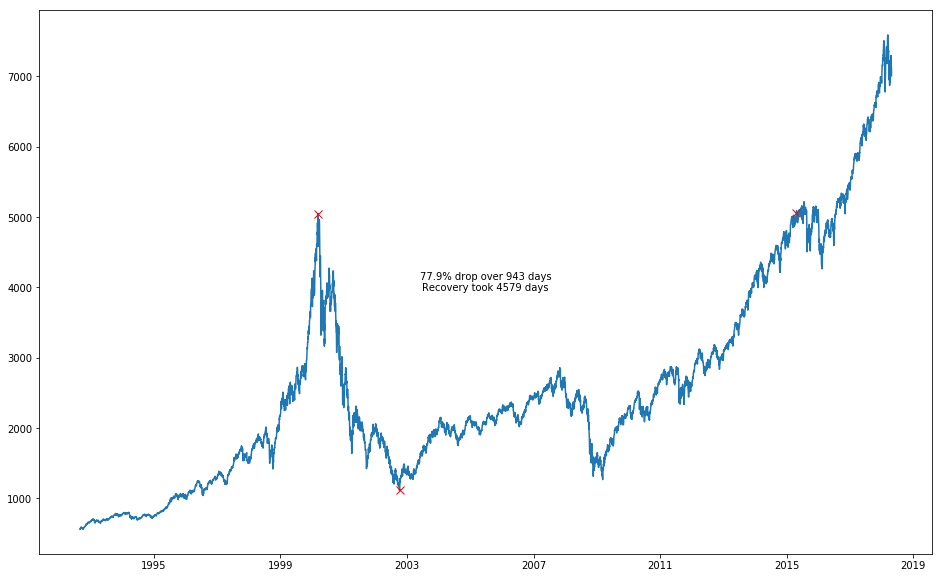

In [17]:
# plot each of the drawdowns to see the patterns

extra_days = 15 # add some extra days on either side

for index, row in nasdaq_drawdowns.iterrows():    
    if index > 0:
        break
    if row['dd'] < 25: # drawdowns of 25% or more
        break
    high = row['highd']
    recovery = row['recoveryd']
    low = row['lowd']
    start = high - timedelta(days=extra_days * row['rdays'].days / 25)
    end = recovery + timedelta(days=extra_days * row['rdays'].days / 25)
    fig, ax = plt.subplots(figsize=(16,10))
    ax.plot(nasdaq_full['Close'].loc[start:end].index, nasdaq_full['Close'].loc[start:end])       
    text = "%.1f%% drop over %d days\nRecovery took %d days" % (row['dd'],row['days'].days,row['rdays'].days)
    ax.plot([high, low, recovery], [nasdaq_full['Close'].loc[high], nasdaq_full['Close'].loc[low], nasdaq_full['Close'].loc[recovery]], 'x', color='Red', markersize=8)
    ax.text(0.5, 0.5,text, horizontalalignment='center', verticalalignment='center', transform = ax.transAxes)
    #fig.savefig("drawdowns/nasdaq/" + high.strftime("%Y-%m-%d") + '.png', dpi=100, bbox_inches='tight')
    #plt.close(fig)

In [37]:
bitcoin_drawdowns.sort_values('highd', ascending = True, inplace = True)
bitcoin_drawdowns.set_index('highd', inplace = True)

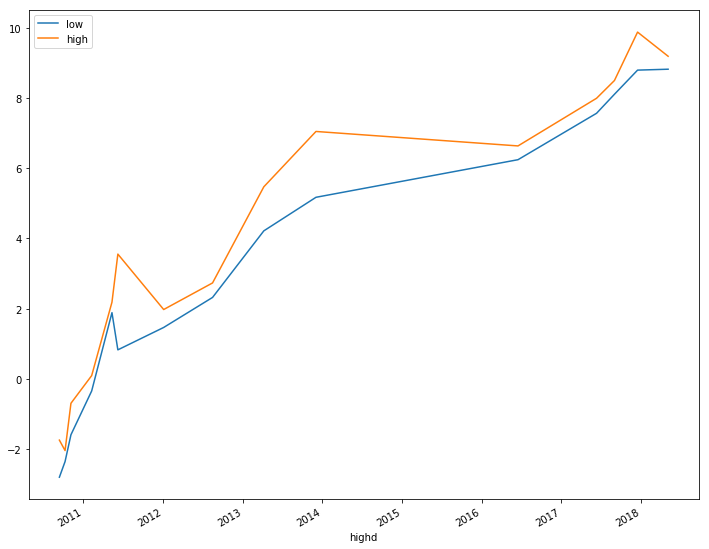

In [41]:
# on a log scale the sequence of lows in each succesive cycle are roughly a straight line (so exp growth)
# same for the sequence of highs
np.log(bitcoin_drawdowns[['low','high']]).plot(figsize=(12,10));